##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adversarial example using FGSM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/adversarial_fgsm"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

## What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. One of the most famous examples of an adversarial image shown below is taken from the aforementioned paper.

![Adversarial Example](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/adversarial_example.png?raw=1)

Here, starting with the image of a panda, the attacker adds small perturbations (distortions) to the original image, which results in the model labelling this image as a gibbon, with high confidence. The process of adding these perturbations is explained below.

## Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

So let's try and fool a pretrained model. In this tutorial, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).

In [333]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

import matplotlib as mpl

import sys, os, array, time
import numpy as np
import IPython

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pathlib

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Load and summary pretrained model

In [334]:
pretrained_model = tf.keras.models.load_model("model_small_b32.h5")
pretrained_model.trainable = False
decode_predictions = pretrained_model

#x_test_model = np.load("esca_dataset_xtest_model_small.npy")
#y_test_model = np.load("esca_dataset_ytest_model_small.npy")

#Check l'architecture
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 45, 32)        896       
                                                                 
 activation (Activation)     (None, 80, 45, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 22, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 40, 22, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 11, 32)       0         
 2D)                                                    

In [335]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.uint8)
  image = tf.image.resize(image, (80, 45))
  #image = tf.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Original image

Exemple Image Dataset

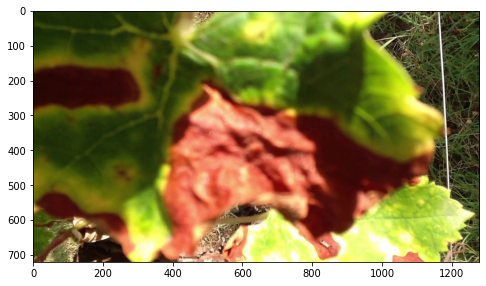

In [336]:
image_path = pathlib.Path('/content/esca_003_cam1.jpg')
img_plt = mpimg.imread(image_path)
img_plt = plt.imshow(img_plt)

(1, 80, 45, 3)
tf.Tensor(
[[[[ 27.722221   45.72222     3.7222223]
   [ 31.         47.         10.       ]
   [ 37.         54.         10.       ]
   ...
   [ 53.88867    65.88867    27.888672 ]
   [ 80.50037    65.167114   36.33374  ]
   [ 55.49951    60.49951    38.22168  ]]

  [[ 23.722221   46.72222     3.2777777]
   [ 28.         44.          7.       ]
   [ 34.388885   51.388885    7.3888855]
   ...
   [ 48.222168   60.222168   24.222168 ]
   [ 89.49988    80.166626   49.333252 ]
   [ 24.444336   30.888672    0.       ]]

  [[ 25.         41.          2.       ]
   [ 25.         43.          5.       ]
   [ 30.         49.          4.       ]
   ...
   [ 54.777832   60.555664   28.166748 ]
   [ 82.000244   90.83362    48.16687  ]
   [ 25.722168   37.722168    1.722168 ]]

  ...

  [[ 57.444443   70.44444    17.444445 ]
   [ 92.16672    67.500046   27.166714 ]
   [107.        118.83334    66.22223  ]
   ...
   [134.2207     99.38745    66.998535 ]
   [ 69.166626   77.833374   23

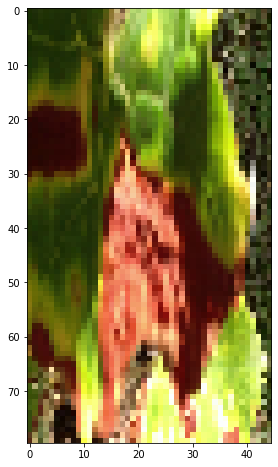

In [337]:
image_raw = tf.io.read_file("/content/esca_003_cam1.jpg") #pathlink
image = tf.image.decode_image(image_raw)

#image = preprocess(image_no_proproc)
image = tf.image.resize(image, (80, 45))
#image = tf.cast(image, tf.uint8)
image = image[None, ...]

print(image.shape)
print(image)
image_probs = pretrained_model.predict(image)
print(image_probs)

#plt.imshow(image[0])
plt.imshow(image[0]/255)
plt.show()

In [338]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [339]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

(1, 80, 45, 3)
tf.Tensor(
[[[0. 1. 0.]
  [0. 1. 0.]
  [1. 1. 0.]
  ...
  [0. 1. 0.]
  [0. 1. 0.]
  [0. 1. 0.]]

 [[0. 1. 0.]
  [0. 1. 0.]
  [0. 1. 0.]
  ...
  [0. 1. 0.]
  [0. 1. 0.]
  [0. 1. 0.]]

 [[1. 1. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  ...
  [0. 1. 0.]
  [0. 1. 0.]
  [1. 1. 1.]]

 ...

 [[0. 1. 0.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 1. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[0. 1. 1.]
  [0. 0. 0.]
  [1. 1. 1.]
  ...
  [0. 0. 1.]
  [1. 0. 1.]
  [1. 1. 0.]]

 [[1. 1. 1.]
  [0. 1. 0.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [1. 0. 1.]
  [1. 1. 1.]]], shape=(80, 45, 3), dtype=float32)


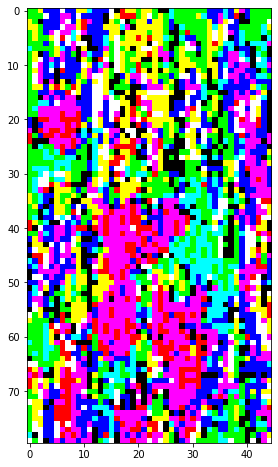

In [340]:
# Get the input label of the image.
labrador_retriever_index = 220
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

print(image.shape)
image_pert = tf.cast(image, tf.float32)
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
print(perturbations[0] * 0.5 + 0.5)

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [341]:
def display_images(image):
  #_, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  #_, label, confidence = pretrained_model.predict(image)
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.show()

In [342]:
b=pretrained_model(image).numpy().argmax()
fig = plt.figure(figsize=(10, 7))
fig.suptitle(f"Images")
rows = 2
columns = 2

<Figure size 720x504 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
prediction original
[[1. 0.]]
1/1 [==============================] - 0s 22ms/step


[[1. 0.]]
1/1 [==============================] - 0s 23ms/step
[[1. 0.]]


1/1 [==============================] - 0s 27ms/step


[[1. 0.]]
1/1 [==============================] - 0s 27ms/step


[[1. 0.]]


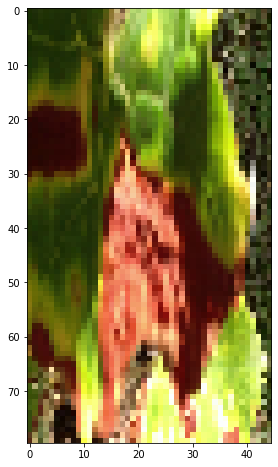

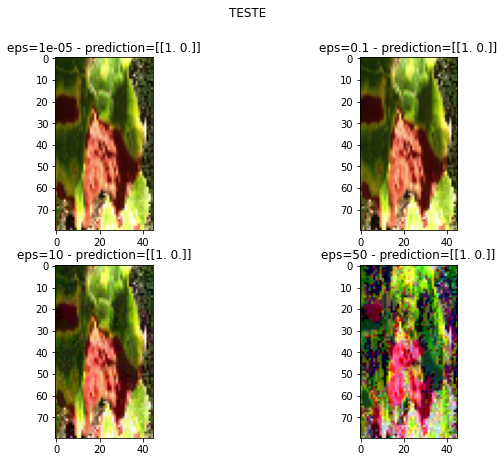

In [343]:
epsilons = [0.00001, 0.1, 10, 50]
#epsilons = [2]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]


#adv_x = 0
prediction = pretrained_model.predict(image)
print("prediction original")
print(prediction)
plt.imshow(image[0]/255)
#image = tf.cast(image, tf.float32)
fig = plt.figure(figsize=(10, 7))
fig.suptitle(f"TESTE")
rows = 2
columns = 2
c = 1
for i, eps in enumerate(epsilons):
  adv_x = image + (eps*perturbations)

  prediction = pretrained_model.predict(adv_x)
  print(prediction)
  
  #adv_x = tf.clip_by_value(adv_x, 0, 1)
  #adv_x = tf.clip_by_value(adv_x, -1, 1)
  #print(adv_x[0])
  fig.add_subplot(rows, columns, c)
  plt.imshow(adv_x[0]/255)
  plt.title(f"eps={eps} - prediction={prediction}")
  c+=1

  

  
  
 

## Next steps

Now that you know about adversarial attacks, try this out on different datasets and different architectures. You may also create and train your own model, and then attempt to fool it using the same method. You can also try and see how the confidence in predictions vary as you change epsilon.

Though powerful, the attack shown in this tutorial was just the start of research into adversarial attacks, and there have been multiple papers creating more powerful attacks since then. In addition to adversarial attacks, research has also led to the creation of defenses, which aims at creating robust machine learning models. You may review this [survey paper](https://arxiv.org/abs/1810.00069) for a comprehensive list of adversarial attacks and defences.

For many more implementations of adversarial attacks and defenses, you may want to see the adversarial example library [CleverHans](https://github.com/tensorflow/cleverhans).